# 1 - Data acquisition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange
%matplotlib inline


In [2]:
data = pd.read_csv("bci05.csv")
data.head()

,tag,sp,gx,gy,dbh,pom,date,codes,status
0,105951,ACACME,610.0,104.7,119.0,1,8924.0,M,A
1,132160,ACACME,534.8,241.3,116.0,1,8922.0,*,A
2,132234,ACACME,539.4,242.3,NaN,0,8922.0,DN,D
3,132235,ACACME,538.8,242.5,NaN,0,8922.0,DN,D
4,191542,ACACME,282.7,177.5,75.0,1,8825.0,*,A


In [3]:
data = data[data["status"]=='A'][["tag", "sp", "gx", "gy"]]

In [4]:
# 1) Species spotting
types = data['sp'].value_counts().keys() 
S = len(types)
print("There are {} different species".format(S))

There are 299 different species


# 2 - Statistics on subplots

Now we divide the total area of study (sampled plot) in 200 subplots of the same area.
To do so we add two columns to the dataset, called $i$ and $j$, that are the result of division without rest respectively of $gx$ and $gy$ for 50 (0.5 hectars in each axis). Then we use some methods of pandas to encode in a 3D matrix the aboundance $x_k$ of each of the S species for each subplot $(i,j)$ and from that we can obtain the average presence of each species.

In [5]:
# 2) Subsampling
# 50 * 50 meters
data["i"], data["j"] = data["gx"]//50, data["gy"]//50
# a)
cell_pop = data.groupby(["i", "j"])["sp"].value_counts()
# b) shaping them in a matrix
cell_pop_M = cell_pop.unstack().stack(dropna = False).fillna(0).astype(int)
cell_pop_M = np.array(cell_pop_M).reshape(20, 10, 299) # (i, j, specie)

# this prints are just for understanding how to work with this dataset
#print("Presence and aboundance in subplot (0,0) : \n", cell_pop_M[0,0,:], '\n')
#print("Aboundances of the various species: \n", cell_pop_M.sum(axis=(0,1)), '\n')

p_i = np.count_nonzero(cell_pop_M, axis = (0,1))/200
#print("Absolute presence for each species: \n", presence, '\n')
#print("Relative presence for each species: \n", p_i, '\n')

And the average squared difference between present and absent species in a subplot (that will be used as a constraint in section 4):

In [6]:
def pairing_p(configs):
    # In each subplot there are more absent species than present (just an observation)
    # S+ - S-
    S_present = np.count_nonzero(configs, axis = (1)).flatten()
    # S_absent = S - S_present -> S_pm = 2*S_present - S
    S_pm = 2*S_present - S # Broadcasting
    # constraint C_0 = < (S+ - S-)^2 >
    return np.mean(np.power(S_pm,2))


C0_exp = pairing_p(cell_pop_M.reshape(200, 299)) /299  #VALUTARE SE DIVIDERE PER S  <-------------

## 3 - Max Ent 1

### Hamiltonian of the system for our constraints.

We start considering a generic entropy:

$$ S[\{p_a\}_{i=1,\ldots,n}] = -K \sum_{a=1}^n p_a ln(p_a), K > 0$$

and following constraints:

$$ \sum_{a=1}^n p_a - 1 = 0 $$

$$\sum_{a=1}^n  p_a f_r(x_a) - <f_r(x)>_{obs} = 0 $$

On the PDF we show that the corresponding Hamiltonian is:

$$H(x_a, \vec{\lambda}) = - \sum_{r=1}^{m}\lambda_i f_i(x_a)$$


### Analytical derivation of the tuned Lagrangian multipliers as functions of the constraints.

Adopting the notation to our specific model, we set $K=1$, and rename:

$x_a \rightarrow \vec{\sigma^{(a)}}, m \rightarrow S, f_r(x) \rightarrow \pi_i(\vec{\sigma}) = \sigma_i$

We start considering the following Hamiltonian:

$H(\vec{\sigma}, \vec{\lambda}) = - \sum_{i=1}^{S}\lambda_i f_i(\sigma) = - \sum_{i=1}^{S}\lambda_i \sigma_i $

Manipulating the partition function

$$Z(\vec{\lambda}) = \sum_{\{\vec{\sigma}\}} \exp\{\sum_{i=1}^S \lambda_i \sigma_i\} = \
    \sum_{\{\vec{\sigma}\}} \prod_{i=1}^S\exp\{\lambda_i \sigma_i\} = \
    \prod_{i=1}^S \sum_{\sigma_i = \pm 1} \exp\{\lambda_i \sigma_i\}  = \
    2^S \prod_{i=1}^S \cosh(\lambda_i)$$

Hence we can compute analytically the expected value for each variable $\sigma_i$ for a given value of $\vec{\lambda}$

$$ <\sigma_i>_{model(\vec{\lambda})} = \sum_{\{\vec{\sigma}\}} \sigma_i P(\vec{\sigma}/\vec{\lambda}) = \
\frac{\sum_{\sigma_i \pm 1} \sigma_i e^{\lambda_i \sigma_i}}{2 cosh(\lambda_i)} = tanh(\lambda_i) $$

Now we impose $\forall i$ $m_i = <\sigma_i>_{model(\vec{\lambda})}$ 

$m_i = tanh(\lambda_i) $

and inverting the system we find

$ \lambda_i = +\frac{1}{2} \cdot ln(\frac{1 + m_i}{1 - m_i} )$

Here we apply the formula just obtained to compute the lagrangian parameters for the model Max Ent 1

In [7]:
m_i = 2*p_i - 1
eps = 10e-06 # a small regularization in order to avoid devergences
l_i = 0.5*np.log((1 - m_i + eps)/(1 + m_i + eps))

## 4 - Max Ent 2

Now we consider a new Hamiltonian

$H(\vec{\sigma}, \vec{\lambda}, K) = - \frac{K}{S}\sum_{i,j}\sigma_i\sigma_j - \sum_{i=1}^{S}\lambda_i \sigma_i$



### Constraints for Max Ent 2

The constraints that we are going to use are:
* $m_i = <\sigma_i>_{model} = C_i(\vec{\sigma}) $ with coupled parameters $\lambda_i, i = 1,\ldots, S$
* $<(S_+ - S_-)^2>_{exp} = <(\sum_{j=1}^{S}\sigma_j)^2>_{model} = C_0(\vec{\sigma})$ with coupled parameter $\lambda_0 = K/S$

To initialize the Lagrange multipliers we have two possible choices: extracting them from a gaussian distribution centered in 0 or to take the initial $\lambda_i$ as the one of the previous point and for $K'$ using a gaussian with variance that is a funtion of S. [WORK IN PROGRESS]

### Gradient descent function

The objective function that we want to minimize is the Kullback–Leibler divergence $D_{KL}(P_{exp}/P_{model})$.

The derivatives of the KL-divergence w.r.t. the Lagrangian multipliers are:

$$ \frac{\partial D_{KL}}{\partial \lambda_a} = <C_a(\vec{\sigma})>_{model}-<C_a(\vec{\sigma})>_{exp} $$

More in concrete:

$$\frac{\partial D_{KL}(t)}{\partial \lambda_0} = <(\sum_{j=1}^{S}\sigma_j)^2>_{model(t)} - <(S_+ - S_-)^2>_{exp}  $$

$$\frac{\partial D_{KL}(t)}{\partial \lambda_i} = <\sigma_i>_{model(t)} - m_i $$


Thus the update rule for gradient descent will be:

$$\lambda_a(t+1) \leftarrow \lambda_a(t) - \eta \cdot \frac{\partial D_{KL}(t)}{\partial \lambda_a}$$


### Stopping criteria
Then we want to run the cycle of Metropolis and gradient descent until a stopping criteria is met.
Possible choices are:
* fixed number of iterations
* margin of improvement under a certain threshold

In [33]:
# FUNCTIONS FOR SAMPLING GOOD CONFIGS WITH METROPOLIS
"""
def compute_dE(test_config, index, lambdas): 
    
    # Compute how many species are presents in in the config (how many spins are +1)
    S_present = np.count_nonzero(test_config+1)
       
    # Compute dE (each term should have sign '-' if we consider negative H, as defined above)
    dE_standard = 2*lambdas[index+1]*test_config[index]
    dE_pairing  = lambdas[0]*2*test_config[index]*(2*S_present-299-test_config[index])
    dE = dE_standard + dE_pairing
    #print('standard:', dE_standard, '   pairing:', dE_pairing)
    print(dE)
    return(dE)

"""
def compute_dE(test_config, index, lambdas):
    
    # Compute E_new
    prod_sum = np.sum(np.outer(test_config,test_config))
    E_new = np.dot(test_config, lambdas[1:]) + prod_sum*lambdas[0]
    
    # Return to old config
    test_config[index] = -test_config[index]
    
    # Compute E_old
    prod_sum = np.sum(np.outer(test_config,test_config))
    E_old = np.dot(test_config, lambdas[1:]) + prod_sum*lambdas[0]
    
    # Compute and print dE
    dE = E_new-E_old
    #print(dE)
    return(dE)
  
    
    
def acceptance_test(config, index, lambdas):
    
    #flip spin at 'index' and compute dE between new and old config
    config[index] = -config[index]
    dE = compute_dE(config, index, lambdas)
    
    #Acceptance Test
    if dE<0:
        return (True)
    else:
        prob_acc = np.random.random()
        if prob_acc < np.exp(-dE):
            return (True)
        else:
            return (False)
        
    
    
def metropolis_sample(lambdas, max_acc, N, M=100):
     
    #First, generate a random configuration and initialize things
    configuration = np.random.choice([+1,-1], size = 299)
    flip_spins = np.random.randint(low = 0, high = 299, size = M)
    acc_rate = 1

    # --- CALIBRATE --- until acc_rate reaches the treshold
    while (acc_rate > max_acc):
        
        #Count how many flips are accepted (over M flips)
        acc_flips = 0
        for i in flip_spins:
            
            #Test acceptance of the config after flipping spin i 
            if acceptance_test(configuration, i, lambdas):
                configuration[i] = -configuration[i]
                acc_flips += 1
            # If flip is not accepted, the configuration is unchanged
            
        #Compute acceptance rate
        acc_rate = acc_flips/M
        print(acc_rate)
    
    # --- SAMPLE --- N configs continuing flipping one spin at time
    sampled_configs = np.zeros(shape=(N,299))
    sample_index = 0
    
    while (sample_index < N):
        
        #choose at random a spin to flip
        spin_index = np.random.randint(low = 0, high = 299)
        
        #Test acceptance of the config after flipping spin, if accepted save it in 'sample_configs'
        if acceptance_test(configuration, spin_index, lambdas):
            configuration[i] = -configuration[i]
            sampled_configs[sample_index] = configuration
            sample_index += 1
            
    return (sampled_configs)

In [34]:
# FUNCTION TO COMPUTE TERMS OF THE KULLBACK-LEIBLER DIVERGENCE

def KL_divergence(configs, exp_constraints):
    
    # Compute pairing constraint
    spin_sums = np.sum(configs, axis=1)
    C0_model = np.mean(np.power(spin_sums,2)) /299  #VALUTARE SE DIVIDERE PER S  <-------------
    
    # Compute 'single-specie' constraints
    Ci_model = np.mean(configs, axis=0)
    
    # Compute KL divergence Terms
    KL_div = np.zeros(300)
    KL_div[0]  = C0_model - exp_constraints[0]
    KL_div[1:] = Ci_model - exp_constraints[1:]
    
    return KL_div
    

In [36]:
# Define constants
eta = 0.5
max_acc = 0.15
N = 100
iterations = 1000

# vectors to save results
every_lambdas = np.zeros((iterations, 300))
errors = np.zeros(iterations)

# We start with l_i from point 3 and random l_0
l_0 = np.random.uniform(-1,1)
lambdas = np.concatenate(([l_0], l_i))

for i in tnrange(iterations):
    
    # Sample N configurations with metropolis
    good_configs = metropolis_sample(lambdas, max_acc, N)

    # Compute all terms of Kullback–Leibler divergences 
    exp_constraints = np.concatenate(([C0_exp], m_i))
    KL_div_values = KL_divergence(good_configs, exp_constraints)
    
    # Gradient descent to update lambdas
    lambdas = lambdas - eta*KL_div_values
    every_lambdas[i] = lambdas
    
    # Estimate error as the norm of the gradient
    errors[i] = np.linalg.norm(KL_div_values)
    print('______ERROR_____: ',errors[i])

0.32
0.16
0.2
0.12
______ERROR_____:  28.260619192079265
0.36
0.17
0.2
0.17
0.16
0.11
______ERROR_____:  29.36686883837652
0.29
0.15
______ERROR_____:  29.63178356291971
0.35
0.11
______ERROR_____:  29.62554616155472
0.37
0.1
______ERROR_____:  29.94082472762582
0.34
0.26
0.11
______ERROR_____:  29.62638346338815
0.3
0.09
______ERROR_____:  31.053711297853102
0.3
0.18
0.15
______ERROR_____:  30.381128770511637
0.29
0.18
0.13
______ERROR_____:  30.893730708992056
0.22
0.14
______ERROR_____:  30.987781416547378
0.28
0.12
______ERROR_____:  31.09490288408069
0.35
0.04
______ERROR_____:  31.76259745549345
0.3
0.11
______ERROR_____:  30.438833701699526
0.22
0.08
______ERROR_____:  30.990040289094804
0.24
0.06
______ERROR_____:  31.53970490303309
0.28
0.04
______ERROR_____:  30.82812004275333
0.23
0.04
______ERROR_____:  30.72071934573992
0.22
0.03
______ERROR_____:  31.3852351491973
0.21
0.04
______ERROR_____:  31.199887585861745
0.28
0.1
______ERROR_____:  31.66753835350026
0.21
0.06
_____

______ERROR_____:  31.310269647040883
0.15
______ERROR_____:  31.38873978627383
0.25
0.05
______ERROR_____:  31.4108675002732
0.23
0.04
______ERROR_____:  31.041794171252565
0.28
0.04
______ERROR_____:  31.178880626470843
0.28
0.11
______ERROR_____:  31.078008255351868
0.21
0.08
______ERROR_____:  31.08975692041367
0.23
0.09
______ERROR_____:  31.406410127865918
0.24
0.05
______ERROR_____:  30.98423142696489
0.15
______ERROR_____:  30.4544411436232
0.36
0.05
______ERROR_____:  31.26168558108167
0.24
0.09
______ERROR_____:  31.13957265876347
0.27
0.04
______ERROR_____:  31.5097222634494
0.18
0.04
______ERROR_____:  31.651265332048244
0.15
______ERROR_____:  31.589279781592342
0.32
0.06
______ERROR_____:  31.319849702232126
0.25
0.05
______ERROR_____:  31.354466940449154
0.2
0.07
______ERROR_____:  30.835087110623164
0.26
0.02
______ERROR_____:  31.901300684618015
0.24
0.06
______ERROR_____:  31.23911965980666
0.23
0.06
______ERROR_____:  31.903332069232498
0.21
0.06
______ERROR_____:  3

______ERROR_____:  30.87771017045159
0.27
0.04
______ERROR_____:  31.39351820631784
0.21
0.06
______ERROR_____:  31.34138792586759
0.26
0.04
______ERROR_____:  31.370575152049888
0.34
0.05
______ERROR_____:  31.0604730384199
0.22
0.04
______ERROR_____:  31.20757897323036
0.3
0.07
______ERROR_____:  31.43171941479514
0.24
0.07
______ERROR_____:  30.45345604969015
0.18
0.06
______ERROR_____:  31.59071042839033
0.2
0.06
______ERROR_____:  31.255607262864206
0.3
0.04
______ERROR_____:  30.73195381635228
0.21
0.04
______ERROR_____:  31.60621751128106
0.24
0.05
______ERROR_____:  31.639737441552985
0.31
0.06
______ERROR_____:  31.94405417475557
0.3
0.02
______ERROR_____:  31.064658140246927
0.25
0.0
______ERROR_____:  30.81951649717625
0.18
0.02
______ERROR_____:  30.958568852103124
0.21
0.03
______ERROR_____:  31.56331093405315
0.27
0.14
______ERROR_____:  31.39288112566939
0.26
0.09
______ERROR_____:  31.720229907275417
0.26
0.04
______ERROR_____:  31.297491678574012
0.23
0.07
______ERROR_

0.18
0.04
______ERROR_____:  31.735043490917256
0.25
0.04
______ERROR_____:  31.119489024078124
0.27
0.06
______ERROR_____:  31.31617149524697
0.31
0.07
______ERROR_____:  31.50083486385272
0.24
0.05
______ERROR_____:  31.530661222367648
0.23
0.04
______ERROR_____:  31.3852351491973
0.26
0.03
______ERROR_____:  31.646209838142052
0.19
0.07
______ERROR_____:  32.05141159715762
0.23
0.04
______ERROR_____:  30.49463226733057
0.27
0.06
______ERROR_____:  31.40035982468543
0.3
0.05
______ERROR_____:  31.307229151103726
0.3
0.05
______ERROR_____:  32.031899680158205
0.26
0.08
______ERROR_____:  31.69184414593776
0.14
______ERROR_____:  30.78007448610886
0.32
0.05
______ERROR_____:  31.01053023362241
0.21
0.02
______ERROR_____:  31.0693192252376
0.22
0.04
______ERROR_____:  31.19042476658051
0.35
0.08
______ERROR_____:  31.698785234933048
0.23
0.02
______ERROR_____:  30.937565925108096
0.24
0.02
______ERROR_____:  30.763825922183504
0.24
0.02
______ERROR_____:  30.967934793434477
0.22
0.0
___

______ERROR_____:  31.31617149524697
0.25
0.05
______ERROR_____:  31.646209838142056
0.23
0.01
______ERROR_____:  31.106311210423502
0.22
0.06
______ERROR_____:  31.205169397388616
0.33
0.05
______ERROR_____:  31.83210010539234
0.28
0.06
______ERROR_____:  31.205976757192033
0.25
0.06
______ERROR_____:  31.25960007933113
0.23
0.09
______ERROR_____:  31.262479062283575
0.32
0.05
______ERROR_____:  31.055798124017336
0.28
0.06
______ERROR_____:  30.529542829371184
0.2
0.08
______ERROR_____:  31.608584231498238
0.23
0.02
______ERROR_____:  30.973256159463098
0.23
0.08
______ERROR_____:  32.04251234094666
0.23
0.06
______ERROR_____:  30.94370671672044
0.17
0.04
______ERROR_____:  31.085896888627964
0.31
0.07
______ERROR_____:  31.475110756274056
0.26
0.09
______ERROR_____:  31.804606354589733
0.16
0.04
______ERROR_____:  31.225351833401636
0.21
0.0
______ERROR_____:  30.812870450031262
0.29
0.08
______ERROR_____:  30.83882269754164
0.34
0.07
______ERROR_____:  30.84919748340967
0.32
0.04
_

______ERROR_____:  31.108882929474
0.23
0.04
______ERROR_____:  31.422491711677
0.29
0.06
______ERROR_____:  31.155304289485112
0.26
0.05
______ERROR_____:  30.690431686760597
0.21
0.08
______ERROR_____:  31.065945750458166
0.18
0.03
______ERROR_____:  31.706355599002695
0.19
0.02
______ERROR_____:  31.43140126323371
0.19
0.06
______ERROR_____:  31.010362737635283
0.26
0.06
______ERROR_____:  31.316171495246973
0.26
0.0
______ERROR_____:  31.45000154403365
0.22
0.04
______ERROR_____:  31.159951815105856
0.23
0.04
______ERROR_____:  30.704934218630232
0.3
0.02
______ERROR_____:  31.055965374955093
0.33
0.04
______ERROR_____:  31.463200494711433
0.26
0.02
______ERROR_____:  30.979557539939297
0.26
0.08
______ERROR_____:  31.40625710539875
0.26
0.1
______ERROR_____:  31.911330047028905
0.28
0.07
______ERROR_____:  31.295408562914126
0.32
0.01
______ERROR_____:  31.050967732418886
0.24
0.03
______ERROR_____:  31.370728348569127
0.26
0.03
______ERROR_____:  31.175673162254554
0.26
0.02
____

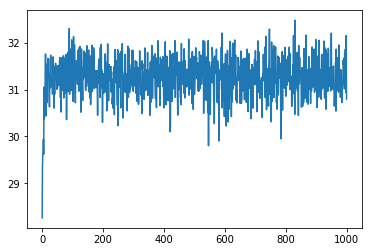

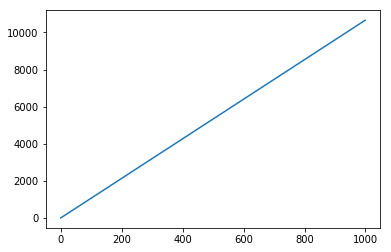

In [37]:
plt.plot(errors)
plt.show()
plt.plot(every_lambdas[:,0])
plt.show()